<a href="https://colab.research.google.com/github/chless/arxiv-course-rl/blob/2022-UNIST/05_Q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q-learning

In [ ]:
import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
print ("plt version:[%s]"%(matplotlib.__version__))
print ("gym version:[%s]"%(gym.__version__))

plt version:[3.2.2]
gym version:[0.17.3]


##### Helper functions


In [ ]:
def display_q_value(Q, title="Q Function",fig_size=8,text_fs=9,title_fs=15):
    """
    Display Q value
    """
    n_state, n_action = Q.shape
    nRow = 4
    # Triangle patches for each action
    lft_tri = np.array([[0,0],[-0.5,-0.5],[-0.5,0.5]])
    dw_tri = np.array([[0,0],[-0.5,0.5],[0.5,0.5]])
    up_tri = np.array([[0,0],[0.5,-0.5],[-0.5,-0.5]])
    rgh_tri = np.array([[0,0],[0.5,0.5],[0.5,-0.5]])
    # Color
    high_color = np.array([1.0, 0.0, 0.0, 0.8])
    low_color  = np.array([1.0, 1.0, 1.0, 0.8])
    fig = plt.figure(figsize=(fig_size,fig_size))
    plt.title(title,fontsize=title_fs)  
    for i in range(nRow):
        for j in range(nRow):
            s = i*nRow+j
            min_q = np.min(Q[s])
            max_q = np.max(Q[s])
            for a in range(n_action):
                q_value = Q[s,a]
                ratio = (q_value - min_q)/(max_q - min_q + 1e-10) 
                if ratio > 1: clr = high_color
                elif ratio < 0: clr = low_color
                else: clr = high_color*ratio + low_color*(1-ratio)
                if a == 0: # Left arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+lft_tri, color=clr, ec='k'))
                    plt.text(j-0.25, i+0.0,"%.2f"%(q_value),fontsize=text_fs,va='center', ha='center')
                if a == 1: # Down arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+dw_tri, color=clr, ec='k'))
                    plt.text(j-0.0, i+0.25,"%.2f"%(q_value),fontsize=text_fs,va='center', ha='center')
                if a == 2: # Right arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+rgh_tri, color=clr, ec='k'))
                    plt.text(j+0.25, i+0.0,"%.2f"%(q_value),fontsize=text_fs,va='center', ha='center')
                if a == 3: # Up arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+up_tri, color=clr, ec='k'))
                    plt.text(j-0.0, i-0.25,"%.2f"%(q_value),fontsize=text_fs,va='center', ha='center')
    plt.xlim([-0.5,nRow-0.5])
    plt.xticks(range(nRow))
    plt.ylim([-0.5,nRow-0.5])
    plt.yticks(range(nRow))
    plt.gca().invert_yaxis()
    plt.show()
    
def visualize_matrix(M,strs='',fontsize=15,cmap='turbo',title='Title',title_fs=15,
                     fig_size=8,REMOVE_TICK_LABELS=True):
    """
    Visualize a matrix colors and strings 
    """
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    n_row,n_col = M.shape[0],M.shape[1]
    fig,ax = plt.subplots(figsize=(fig_size,fig_size))
    divider = make_axes_locatable(ax)
    im = ax.imshow(M,cmap=plt.get_cmap(cmap),extent=(0,n_col,n_row,0),
              interpolation='nearest',aspect='equal')
    ax.set_xticks(np.arange(0,n_col,1))
    ax.set_yticks(np.arange(0,n_row,1))
    ax.grid(color='w', linewidth=2)
    ax.set_frame_on(False)
    x,y = np.meshgrid(np.arange(0,n_col,1.0),np.arange(0,n_row,1.0))
    if len(strs) == n_row*n_col:
        idx = 0
        for x_val,y_val in zip(x.flatten(), y.flatten()):
            c = strs[idx]
            idx = idx + 1
            ax.text(x_val+0.5,y_val+0.5,c,va='center', ha='center',size=fontsize)
    cax = divider.append_axes('right', size='5%', pad=0.05)            
    fig.colorbar(im, cax=cax, orientation='vertical')
    fig.suptitle(title,size=title_fs) 
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    if REMOVE_TICK_LABELS:
        plt.setp(ax.get_xticklabels(),visible=False)
        plt.setp(ax.get_yticklabels(),visible=False)
    plt.show()

### Q Learning
To implement model-free policy iteration, we need to estimate the followings using samples:

$Q_{k+1}(s,a) = \sum_{s'} \left[r(s,a,s') + \gamma \max_{a'} Q_{k}(s',a') \right] P(s'|s,a)$

Update Q value using temporal difference (TD) target and error:

$Q_{new}(S_{t}, A_{t}) \leftarrow Q_{old}(S_{t}, A_{t}) + \alpha (R_{t+1} + \gamma \max_{a'} Q_{old}(S_{t+1},a') - Q_{old}(S_{t}, A_{t}))$

We can update our estimator online, just $(S_{t},A_{t},R_{t+1},S_{t+1})$ is needed.
$A_{t+1}$ is not needed.

TD target is $R_{t+1} + \gamma \max_{a'} Q_{old}(S_{t+1},a')$

TD error is $R_{t+1} + \gamma \max_{a'} Q_{old}(S_{t+1},a') - Q(S_{t},A_{t})$

Algorithm
--
---
For every time step

Policy Evaluation

- Collect $(S_{t},A_{t},R_{t+1},S_{t+1})$

- $\text{TD target} = R_{t+1} + \gamma \max_{a'} Q_{old}(S_{t+1},a')$

- $\text{TD error} = R_{t+1} + \gamma \max_{a'} Q_{old}(S_{t+1},a') - Q(S_{t},A_{t})$

- $Q[S_{t}, A_{t}] = Q[S_{t}, A_{t}] + \alpha \text{TD target}$

Policy Improvement

- $\pi(a|s) = \frac{\epsilon}{m} + (1-\epsilon) \mathbf{1}\left(a = \max_{a'} Q(s,a')\right)$

In [ ]:
class Q_learningAgent():
    def __init__(self,n_state,n_action,alpha=0.5,epsilon=1.0,gamma=0.999):
        self.n_state = n_state
        self.n_action = n_action
        self.alpha_init = alpha
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        
        # Initial Q value
        self.Q = np.zeros([n_state,n_action])
        
    def update_Q(self,state,action,reward,state_prime,done):
        """
        Update value
        """
        Q_old = self.Q[state][action]
        # TD target
        if done:
            td_target = reward
        else:
            td_target = reward + self.gamma*np.max(self.Q[state_prime])
        td_error = td_target - Q_old # TD error
        self.Q[state,action] = Q_old + self.alpha*td_error # update Q
        
    def update_epsilon(self,epsilon):
        self.epsilon = np.min([epsilon,1.0]) 
        
    def update_alpha(self,alpha):
        self.alpha = np.min([alpha,self.alpha_init]) 
        
    def get_action(self,state):
        """
        Get action
        """
        if np.random.uniform() < self.epsilon:
            action = np.random.randint(0,high=self.n_action)
        else:
            action = np.argmax(self.Q[state])
        return action 
    

### Run Q learning agent

3,000 episodes

In [ ]:
env = gym.make('FrozenLake-v0')
n_state = env.observation_space.n
n_action = env.action_space.n
# epsilon=1.0 -> random policy
agent = Q_learningAgent(n_state,n_action,epsilon=1.0,alpha=0.1,gamma=0.999)
# Loop 
n_episode = 3000
for e_idx in range(n_episode):
    state = env.reset()
    action = agent.get_action(state)
    done = False
    while not done:
        state_prime, reward, done, info = env.step(action)
        action_prime = agent.get_action(state_prime)
        agent.update_Q(state, action, reward, state_prime, done)
        state = state_prime
        action = action_prime
        
    # agent.update_epsilon(1000/(e_idx+1)) # reduce randomness
    agent.update_alpha(1000/(e_idx+1)) # reduce update rate
print ("Q-learning done.")

Q-learning done.


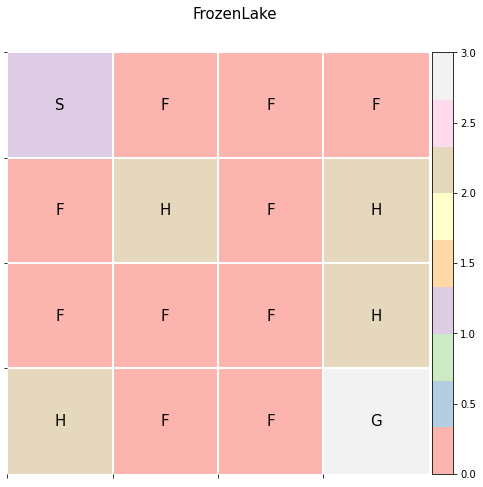

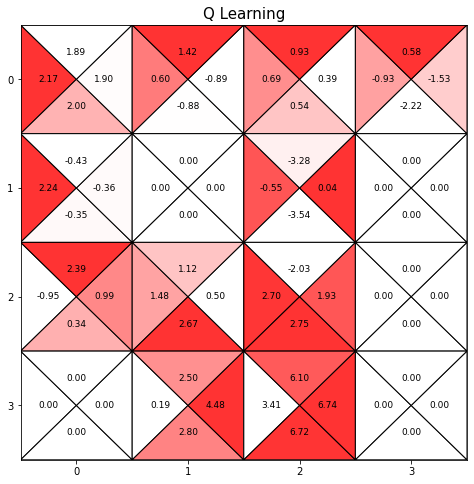

In [ ]:
# Plot env
E = np.zeros(shape=(4,4))
strs = ['S','F','F','F',
        'F','H','F','H',
        'F','F','F','H',
        'H','F','F','G',]
E[0,0] = 1 # Start
E[1,1]=E[1,3]=E[2,3]=E[3,0]=2 # Hole
E[3,3] = 3 # Goal

visualize_matrix(E,strs=strs,cmap='Pastel1',title='FrozenLake',fig_size=7)
display_q_value(agent.Q,title="Q Learning",fig_size=8,text_fs=9,title_fs=15)    

### Cliff Walking

In [ ]:
from gym.envs.toy_text.cliffwalking import CliffWalkingEnv

In [ ]:
env = CliffWalkingEnv()

In [ ]:
env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



In [ ]:
# 4x12 grid = 48 states
print ("Number of states:", env.nS)
print ("Number of actions that an agent can take:", env.nA)
action_space = ["up", "right", "down", "left"]

Number of states: 48
Number of actions that an agent can take: 4


In [ ]:
print ("Current state", env.s)
print ("Transitions from current state:", env.P[env.s])

Current state 36
Transitions from current state: {0: [(1.0, 24, -1, False)], 1: [(1.0, 36, -100, False)], 2: [(1.0, 36, -1, False)], 3: [(1.0, 36, -1, False)]}


In [ ]:
for s in range(48):
    for a in range(4):
        if env.P[s][a][0][2] == -100:
            env.P[s][a][0] = (env.P[s][a][0][0], env.P[s][a][0][1], env.P[s][a][0][2], True)

In [ ]:
env.P

{0: {0: [(1.0, 0, -1, False)],
  1: [(1.0, 1, -1, False)],
  2: [(1.0, 12, -1, False)],
  3: [(1.0, 0, -1, False)]},
 1: {0: [(1.0, 1, -1, False)],
  1: [(1.0, 2, -1, False)],
  2: [(1.0, 13, -1, False)],
  3: [(1.0, 0, -1, False)]},
 2: {0: [(1.0, 2, -1, False)],
  1: [(1.0, 3, -1, False)],
  2: [(1.0, 14, -1, False)],
  3: [(1.0, 1, -1, False)]},
 3: {0: [(1.0, 3, -1, False)],
  1: [(1.0, 4, -1, False)],
  2: [(1.0, 15, -1, False)],
  3: [(1.0, 2, -1, False)]},
 4: {0: [(1.0, 4, -1, False)],
  1: [(1.0, 5, -1, False)],
  2: [(1.0, 16, -1, False)],
  3: [(1.0, 3, -1, False)]},
 5: {0: [(1.0, 5, -1, False)],
  1: [(1.0, 6, -1, False)],
  2: [(1.0, 17, -1, False)],
  3: [(1.0, 4, -1, False)]},
 6: {0: [(1.0, 6, -1, False)],
  1: [(1.0, 7, -1, False)],
  2: [(1.0, 18, -1, False)],
  3: [(1.0, 5, -1, False)]},
 7: {0: [(1.0, 7, -1, False)],
  1: [(1.0, 8, -1, False)],
  2: [(1.0, 19, -1, False)],
  3: [(1.0, 6, -1, False)]},
 8: {0: [(1.0, 8, -1, False)],
  1: [(1.0, 9, -1, False)],
  2: 

In [ ]:
import random
from time import sleep

env.reset()
env.render()
is_terminal = False
while not is_terminal:
    rnd_action = random.randint(0, 3)
    print("Action taken:", action_space[rnd_action])
    next_state, reward, is_terminal, t_prob = env.step(rnd_action)
    print("Transition probability:", t_prob)
    print("Next state:", next_state)
    print("Reward recieved:", reward)
    print("Terminal state:", is_terminal)
    env.render()
    sleep(1)

In [ ]:
n_state = env.observation_space.n
n_action = env.action_space.n
agent = Q_learningAgent(n_state,n_action,epsilon=1.0,alpha=0.1,gamma=0.999)

# Loop
n_episode = 10000
for e_idx in range(n_episode):
    state = env.reset() # reset environment, select initial 
    action = agent.get_action(state)
    done = False
    while not done:
        state_prime, reward, done, info = env.step(action) # step 
        action_prime = agent.get_action(state_prime) # Get next action
        agent.update_Q(state, action, reward, state_prime, done) # learns Q
        state = state_prime
        action = action_prime
    agent.update_epsilon(100/(e_idx+1)) # Decaying epsilon
print ("Q-learning done.")

Q-learning done.


In [ ]:
is_terminal = False
state = env.reset()
env.render()
while not is_terminal:
    action = agent.get_action(state)
    print("Action taken:", action_space[action])
    next_state, reward, is_terminal, t_prob = env.step(action)
    print("Transition probability:", t_prob)
    print("Next state:", next_state)
    print("Reward recieved:", reward)
    print("Terminal state:", is_terminal)
    state = next_state
    env.render()
    sleep(1)

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Action taken: up
Transition probability: {'prob': 1.0}
Next state: 24
Reward recieved: -1
Terminal state: False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Action taken: right
Transition probability: {'prob': 1.0}
Next state: 25
Reward recieved: -1
Terminal state: False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Action taken: right
Transition probability: {'prob': 1.0}
Next state: 26
Reward recieved: -1
Terminal state: False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Action taken: right
Transition probability: {'prob': 1.0}
Next state: 27
Reward recieved: -1
T

When penalty is much larger (-100 -> -1000)

In [ ]:
for s in range(48):
    for a in range(4):
        if env.P[s][a][0][2] == -100:
            env.P[s][a][0] = (env.P[s][a][0][0], env.P[s][a][0][1], -1000, True)

In [ ]:
env.P

{0: {0: [(1.0, 0, -1, False)],
  1: [(1.0, 1, -1, False)],
  2: [(1.0, 12, -1, False)],
  3: [(1.0, 0, -1, False)]},
 1: {0: [(1.0, 1, -1, False)],
  1: [(1.0, 2, -1, False)],
  2: [(1.0, 13, -1, False)],
  3: [(1.0, 0, -1, False)]},
 2: {0: [(1.0, 2, -1, False)],
  1: [(1.0, 3, -1, False)],
  2: [(1.0, 14, -1, False)],
  3: [(1.0, 1, -1, False)]},
 3: {0: [(1.0, 3, -1, False)],
  1: [(1.0, 4, -1, False)],
  2: [(1.0, 15, -1, False)],
  3: [(1.0, 2, -1, False)]},
 4: {0: [(1.0, 4, -1, False)],
  1: [(1.0, 5, -1, False)],
  2: [(1.0, 16, -1, False)],
  3: [(1.0, 3, -1, False)]},
 5: {0: [(1.0, 5, -1, False)],
  1: [(1.0, 6, -1, False)],
  2: [(1.0, 17, -1, False)],
  3: [(1.0, 4, -1, False)]},
 6: {0: [(1.0, 6, -1, False)],
  1: [(1.0, 7, -1, False)],
  2: [(1.0, 18, -1, False)],
  3: [(1.0, 5, -1, False)]},
 7: {0: [(1.0, 7, -1, False)],
  1: [(1.0, 8, -1, False)],
  2: [(1.0, 19, -1, False)],
  3: [(1.0, 6, -1, False)]},
 8: {0: [(1.0, 8, -1, False)],
  1: [(1.0, 9, -1, False)],
  2: 

In [ ]:
n_state = env.observation_space.n
n_action = env.action_space.n
agent = Q_learningAgent(n_state,n_action,epsilon=1.0,alpha=0.1,gamma=0.999)

# Loop
n_episode = 10000
for e_idx in range(n_episode):
    state = env.reset() # reset environment, select initial 
    action = agent.get_action(state)
    done = False
    while not done:
        state_prime, reward, done, info = env.step(action) # step 
        action_prime = agent.get_action(state_prime) # Get next action
        agent.update_Q(state, action, reward, state_prime, done) # learns Q
        state = state_prime
        action = action_prime
    agent.update_epsilon(100/(e_idx+1)) # Decaying epsilon
print ("Q-learning done.")

Q-learning done.


In [ ]:
is_terminal = False
state = env.reset()
env.render()
while not is_terminal:
    action = agent.get_action(state)
    print("Action taken:", action_space[action])
    next_state, reward, is_terminal, t_prob = env.step(action)
    print("Transition probability:", t_prob)
    print("Next state:", next_state)
    print("Reward recieved:", reward)
    print("Terminal state:", is_terminal)
    state = next_state
    env.render()
    sleep(1)

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Action taken: up
Transition probability: {'prob': 1.0}
Next state: 24
Reward recieved: -1
Terminal state: False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Action taken: right
Transition probability: {'prob': 1.0}
Next state: 25
Reward recieved: -1
Terminal state: False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Action taken: right
Transition probability: {'prob': 1.0}
Next state: 26
Reward recieved: -1
Terminal state: False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Action taken: right
Transition probability: {'prob': 1.0}
Next state: 27
Reward recieved: -1
T